In [39]:
import frgtools.misc as frgm
import frgtools.jv as jv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
# style.use('ggplot') or plt.style.use('ggplot')
import pandas as pd
import os
from scipy.optimize import curve_fit
from tqdm import tqdm
import seaborn as sns

In [51]:
from importlib import reload
reload(jv)

<module 'frgtools.jv' from '/Users/rishi/Documents/GitHub/Python-Utilities/FrgTools/frgtools/jv.py'>

# Loading Raw Data File

In [52]:
fids = frgm.listdir('Data')

Files in 'Data':
0:20200312_Optimization.txt
1:ExportedMeasurements.txt
2:20200312_Optimization.csv


In [53]:
data = jv.load_tracer(fids[0])
df = pd.DataFrame(data)

TypeError: 'int' object is not iterable

In [54]:
df.head()

,id,device,curvetype,area,date,time,v,i,p,j,direction,voc,jsc,ff,pce,vmpp
0,(1 of 2),C5SAED2_P1_S1,illuminated,0.07,3/12/2020,5:49:51 PM,"[-0.19873754, -0.19381961, -0.1836413568, -0.1...","[0.00153846448, 0.00154250023, 0.00153774783, ...","[-0.000305750646132579, -0.00029896679300351, ...","[0.021978064, 0.022035717571428567, 0.02196782...",reverse,1.035202,0.021897,0.695325,0.157615,0.851886
1,(2 of 2),C5SAED2_P1_S1,illuminated,0.07,3/12/2020,5:49:51 PM,"[-0.214153689, -0.202462888, -0.1933988712, -0...","[0.00159891889, 0.0015935856, 0.001587716662, ...","[-0.000342414378705285, -0.000322641942851213,...","[0.02284169842857143, 0.022765508571428568, 0....",forward,0.914714,0.021023,0.518887,0.099784,0.654879
2,(1 of 2),C5SAED2_P2_S1,illuminated,0.07,3/12/2020,5:50:25 PM,"[-0.205288765, -0.190382889, -0.1829226124, -0...","[0.00153625266, 0.00153351444, 0.001534547852,...","[-0.000315375411299365, -0.000291954909410417,...","[0.02194646657142857, 0.02190734914285714, 0.0...",reverse,1.034361,0.021671,0.694530,0.155682,0.833903
3,(2 of 2),C5SAED2_P2_S1,illuminated,0.07,3/12/2020,5:50:25 PM,"[-0.213724807, -0.203169147, -0.1932984842, -0...","[0.00159707417, 0.00158883642, 0.00158376725, ...","[-0.000341334368747935, -0.000322802540173934,...","[0.022815345285714283, 0.02269766314285714, 0....",forward,0.941193,0.021033,0.516741,0.102295,0.636039
4,(1 of 2),C5SAED2_P2_S2,illuminated,0.07,3/12/2020,5:51:59 PM,"[-0.203559405, -0.192030376, -0.1842162564, -0...","[0.00151826952, 0.00151499566, 0.001516576718,...","[-0.000309058040120836, -0.000290925186228168,...","[0.02168956457142857, 0.021642795142857142, 0....",reverse,1.036091,0.021617,0.676795,0.151586,0.814789


In [7]:
dfc = df.dropna() # note that this will drop dark curves as well
dfc = dfc[
    (dfc['ff'] <= 1) #nothing should have more than 100% fill factor
    & (dfc['pce'] >= 0.05) #removing data with pce below 5%, can be modified/removed depending on analysis
]

## Quick Summary Statistics

In [50]:
columns = ['pce', 'ff', 'jsc', 'voc', 'vmpp']
dfc[columns].describe()

,pce,ff,jsc,voc,vmpp
count,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.096328,0.538834,0.019239,0.792664,0.595847
std,0.053076,0.153613,0.004612,0.325245,0.273394
min,0.000088,0.262404,0.000054,0.007673,0.006502
25%,0.058247,0.410745,0.019528,0.752059,0.483401
50%,0.108767,0.564674,0.021016,0.950898,0.710588
75%,0.139770,0.674204,0.021500,0.997971,0.795958
max,0.171119,1.000000,0.022417,1.044184,0.939388


## Label experimental conditions

The specific functions here will be dependent on your experiment. The goal is to make a column for each condition varied in your dataset, with the condition marked per row. This will speed up data analysis, since the dataframe can be sliced/analyzed along experimental condtions

In [9]:
def pbexcess(name):
    if 'C5' in name:
        return 0.05
    elif 'C9' in name:
        return 0.09
    else:
        return np.nan
dfc['pb_excess'] = dfc['device'].apply(pbexcess)

In [10]:
def anneal(name):
    if 'SA' in name:
        return 'standard'
    elif 'EA' in name:
        return 'experimental'
    else:
        return np.nan
dfc['anneal'] = dfc['device'].apply(anneal)

In [11]:
def droptime(name):
    if 'SD' in name:
        return 'standard'
    elif 'ED' in name:
        return 'experimental'
    else:
        return np.nan
dfc['antisolventdrop'] = dfc['device'].apply(droptime)

In [12]:
def pixel(name):
    if '_P1_' in name:
        return 1
    elif '_P2_' in name:
        return 2
    elif '_P3_' in name:
        return 3
    else:
        return np.nan
dfc['pixel'] = dfc['device'].apply(pixel)

In [13]:
dfc.head()

,id,device,curvetype,area,date,time,v,i,p,j,...,jfit,voc,jsc,vmpp,pce,ff,pb_excess,anneal,antisolventdrop,pixel
0,(1 of 2),C5SAED2_P1_S1,illuminated,0.07,3/12/2020,5:49:51 PM,"[-0.19873754, -0.19381961, -0.1836413568, -0.1...","[0.00153846448, 0.00154250023, 0.00153774783, ...","[-0.000305750646132579, -0.00029896679300351, ...","[0.021978064, 0.022035717571428567, 0.02196782...",...,"[0.024086749486708196, 0.024086749485541417, 0...",1.035202,0.021897,0.851886,0.157615,0.695325,0.05,standard,experimental,1
1,(2 of 2),C5SAED2_P1_S1,illuminated,0.07,3/12/2020,5:49:51 PM,"[-0.214153689, -0.202462888, -0.1933988712, -0...","[0.00159891889, 0.0015935856, 0.001587716662, ...","[-0.000342414378705285, -0.000322641942851213,...","[0.02284169842857143, 0.022765508571428568, 0....",...,"[0.023125709847170852, 0.0231257098389506, 0.0...",0.914714,0.021023,0.654879,0.099784,0.518887,0.05,standard,experimental,1
2,(1 of 2),C5SAED2_P2_S1,illuminated,0.07,3/12/2020,5:50:25 PM,"[-0.205288765, -0.190382889, -0.1829226124, -0...","[0.00153625266, 0.00153351444, 0.001534547852,...","[-0.000315375411299365, -0.000291954909410417,...","[0.02194646657142857, 0.02190734914285714, 0.0...",...,"[0.023837905324219602, 0.023837905321996568, 0...",1.034361,0.021671,0.833903,0.155682,0.694530,0.05,standard,experimental,2
3,(2 of 2),C5SAED2_P2_S1,illuminated,0.07,3/12/2020,5:50:25 PM,"[-0.213724807, -0.203169147, -0.1932984842, -0...","[0.00159707417, 0.00158883642, 0.00158376725, ...","[-0.000341334368747935, -0.000322802540173934,...","[0.022815345285714283, 0.02269766314285714, 0....",...,"[0.0231364590165551, 0.023136459011844135, 0.0...",0.932762,0.021033,0.636039,0.102295,0.521411,0.05,standard,experimental,2
4,(1 of 2),C5SAED2_P2_S2,illuminated,0.07,3/12/2020,5:51:59 PM,"[-0.203559405, -0.192030376, -0.1842162564, -0...","[0.00151826952, 0.00151499566, 0.001516576718,...","[-0.000309058040120836, -0.000290925186228168,...","[0.02168956457142857, 0.021642795142857142, 0....",...,"[0.023779239534958134, 0.023779239533960543, 0...",1.036091,0.021617,0.814789,0.151586,0.676795,0.05,standard,experimental,2


Save your cleaned up dataframe

In [14]:
dfc.to_csv('Cleaned_Dataframe.csv')

## Data Visualization

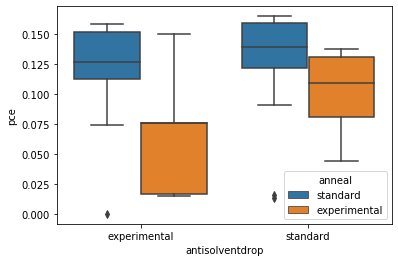

In [17]:
sns.boxplot(
    x = 'antisolventdrop',
    hue = 'anneal',
    y = 'pce',
    data = dfc[dfc['pixel'] == 2], #specifying pixel 2 (center pixel) for analysis
)

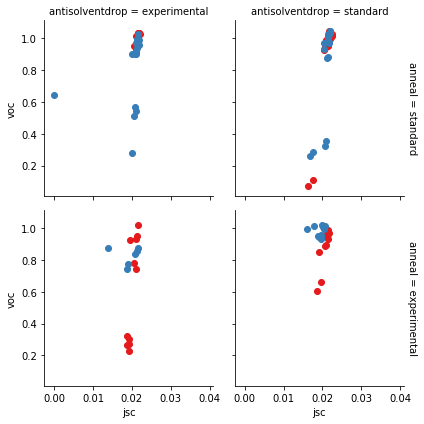

In [21]:
g = sns.FacetGrid(
    dfc, 
    col = "antisolventdrop", 
    row = "anneal", 
    hue = "pb_excess",
    palette = 'Set1',
    margin_titles = True
)

g = g.map(plt.scatter, "jsc", 'voc')

# Plotting the Subset

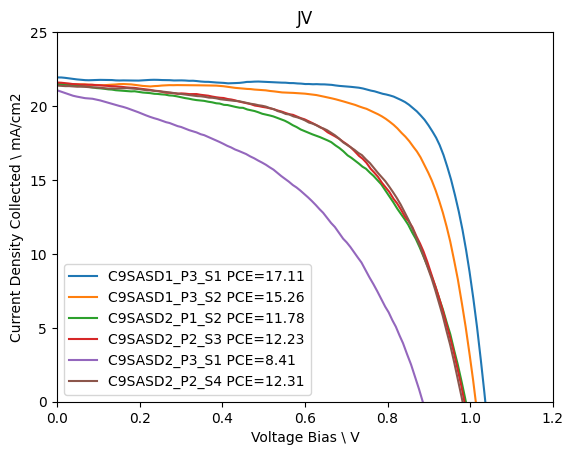

In [19]:
# filtered DataFrame to Plot
DF = df_filter3 

mpl.rcParams.update(mpl.rcParamsDefault)

for q in range (0, len(DF), 1):

    plt.plot(DF.loc[q]['Voltage'],DF.loc[q]['Current']/np.float(DF.loc[q]['Size'])*1000, label=DF.loc[q]['Device']+ ' PCE='+ str(round(DF.loc[q]['PCE'],2)))
#     plt.plot(DF.loc[q]['Voltage'],DF.loc[q]['Power']/np.float(DF.loc[q]['Size'])*1000, label=DF.loc[q]['Device']+' '+'Power Curve')

plt.legend()
plt.title('JV')
plt.ylim(0,25)
plt.xlim(0,1.2)

plt.ylabel('Current Density Collected \ mA/cm2')
plt.xlabel('Voltage Bias \ V')
plt.show()